In [1]:
import networkx as nx
import numpy as np
import itertools as it
import random
import time
import scipy
from matplotlib import pyplot as plt
import fresnel

In [2]:
np.random.seed(100)
random.seed(100)

In [3]:
def coordination_pattern(x):
    """
    To do: obtain the neighbors of an input atom position
    Args:
        x: the position of atoms
    Returns:
        the neighbors of the atoms, excluding the center atoms
    """
    return np.array([x+np.array([0.5,0.5,0]),
                     x+np.array([-0.5,0.5,0]),
                     x+np.array([0.5,-0.5,0]),
                     x+np.array([-0.5,-0.5,0]),
                     x+np.array([0.5,0,0.5]),
                     x+np.array([0.5,0,-0.5]),
                     x+np.array([-0.5,0,0.5]),
                     x+np.array([-0.5,0,-0.5]),
                     x+np.array([0,0.5,0.5]),
                     x+np.array([0,-0.5,0.5]),
                     x+np.array([0,0.5,-0.5]),
                     x+np.array([0,-0.5,-0.5]),
                    ])
def neighbors(x):
    """
    To do: obtain the occupied sites for a given cell
    Args:
        x: the position of cells
    Returns:
        the occupied sites in the cells
    """
    #define sites of fcc cell where x is the body center
    return np.array([x+np.array([0.5,0,0]),
                     x+np.array([-0.5,0,0]),
                     x+np.array([0,-0.5,0]),
                     x+np.array([0,0.5,0]),
                     x+np.array([0,0,0.5]),
                     x+np.array([0,0,-0.5]),      
                     x+np.array([0.5,0.5,0.5]),
                     x+np.array([-0.5,-0.5,0.5]),
                     x+np.array([0.5,-0.5,0.5]),
                     x+np.array([-0.5,0.5,0.5]),           
                     x+np.array([0.5,0.5,-0.5]),
                     x+np.array([-0.5,-0.5,-0.5]),
                     x+np.array([0.5,-0.5,-0.5]),
                     x+np.array([-0.5,0.5,-0.5])   
                    ])
    

In [4]:
position = []
for x in range(-100,100):
    for y in range(-100,100):
        for z in range(-100,100):
            if abs(x)+abs(y)+abs(z)<=16:
                position.append([x,y,z])
position = np.array(position)
print(len(position))
position = np.array(neighbors(position).flatten().reshape(-1,3))
position = np.unique(position,axis=0)
print(len(position))
position = position.tolist()

dipole_position = []
for x in range(-20,20):
    for y in range(-20,20):
        for z in range(-20,20):
            dipole_position.append([x,y,z])
dipole_position = np.array(dipole_position)

6017
27438


In [5]:
# calculate how many atoms exist in individual dipoles
dipole_position_neighbor = neighbors(dipole_position)
atom_num = []
for index in range(dipole_position_neighbor.shape[1]):
    dipole_position_neighbor_tmp = dipole_position_neighbor[:,index].tolist()
    atom_num.append(sum([(i in position) for i in dipole_position_neighbor_tmp]))

# create a hashable dictionary for individual diples
atom_num_dic = {}
for i in range(len(dipole_position)):
    atom_num_dic[tuple(dipole_position[i].tolist())] = atom_num[i]

In [6]:
# initialie the change number
dipole_change_count = []

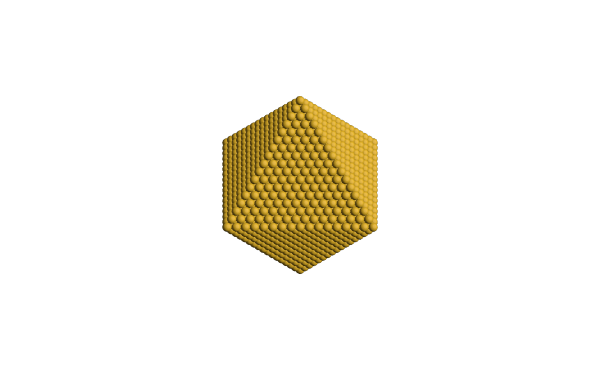

In [7]:
selected_dipoles = np.array(list(atom_num_dic.values())) == 14
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(dipole_position[selected_dipoles]), radius=np.sqrt(2)/2)
geometry.position[:] = dipole_position[selected_dipoles]
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [8]:
for step in range(1,20428):
    # read in the temporary steps 
    atoms_changes_type = np.loadtxt(f'./data1/atoms_changes_type{step*100}.csv',delimiter=',')
    atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
    count = 0 
    for change_type in atoms_changes_type:
        same_time_dipole_change_number = 0
        if change_type ==3:
            pass
        # addition event
        elif change_type ==1:
            # get the atoms to be added
            x = atoms_changes[count]
            # check if it is in the surface or at the corner
            index = np.where(np.around(x) != x)[0]
            # if at the surface
            if len(index) == 1:
                i = index[0]
                
                # get the top cell
                x_tmp = x.copy() # 1
                x_tmp[i] = x_tmp[i]+0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] + 1

                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 14:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([1]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
                    
                # get the bottom cell
                x_tmp = x.copy() #2
                x_tmp[i] = x_tmp[i]-0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] + 1
                
                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 14:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([1]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
            # if at the corner
            elif len(index)==3:
                x_temp = neighbors(x)
                for i in x_temp[-8:]:
                    atom_num_dic[tuple(i.tolist())] = atom_num_dic[tuple(i.tolist())] + 1
                    # check if the dipoles are fully occupied now
                    if atom_num_dic[tuple(i.tolist())] == 14:
                        dipole_change_count.append(np.concatenate((i,np.array([1]))))
                        same_time_dipole_change_number = same_time_dipole_change_number + 1
            else:
                pass
            
            # change the count number
            position.append(x.tolist())
            count = count +1
        # deletion event
        else:
            # get the atoms to be deleted
            x = atoms_changes[count]
            # check if it is in the surface or at the corner
            index = np.where(np.around(x) != x)[0]
            # if at the surface
            if len(index) == 1:
                i = index[0]
                # get the top cell
                x_tmp = x.copy()
                x_tmp[i] = x_tmp[i]+0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] - 1
                
                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 13:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([0]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
                    
                # get the bottom cell
                x_tmp = x.copy()
                x_tmp[i] = x_tmp[i]-0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] - 1
                
                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 13:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([0]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
            # if at the corner
            elif len(index)==3:
                x_temp = neighbors(x)
                for i in x_temp[-8:]:
                    atom_num_dic[tuple(i.tolist())] = atom_num_dic[tuple(i.tolist())] - 1
                    # check if the dipoles are fully occupied now
                    if atom_num_dic[tuple(i.tolist())] == 13:
                        dipole_change_count.append(np.concatenate((i,np.array([0]))))
                        same_time_dipole_change_number = same_time_dipole_change_number + 1
            else:
                pass            
            
            position.remove(x.tolist())
            count = count +1
        if same_time_dipole_change_number > 1:
            dipole_change_count_temp = dipole_change_count[-same_time_dipole_change_number:].copy()
            np.random.shuffle(dipole_change_count_temp)
            dipole_change_count[-same_time_dipole_change_number:] = dipole_change_count_temp

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes12700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes18000.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes18200.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes18300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes18600.csv"
  atoms_changes =  np.loadtxt(f'./data1/ato

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes35900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes36000.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes36100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes36200.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes36300.csv"
  atoms_changes =  np.loadtxt(f'./data1/ato

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes70600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes70700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes70900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes71000.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes71100.csv"
  atoms_changes =  np.loadtxt(f'./data1/ato

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes104900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes105000.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes105200.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes105300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes105400.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes138100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes138300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes138400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes138700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes138900.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes169000.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes169100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes169400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes169700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes170000.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes199900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes200200.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes200300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes200900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes201100.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes229300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes229500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes229900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes230200.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes230500.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes258100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes258300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes258600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes258700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes258800.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes286600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes287300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes287500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes287900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes288700.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes314300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes314400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes315300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes315500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes316300.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes340100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes340400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes340800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes341500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes342200.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes365500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes365600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes366100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes367000.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes367100.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes389600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes389800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes390400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes390500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes390900.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes437300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes437400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes437500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes438300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes440000.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes485400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes485700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes486600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes486800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes487100.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes535900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes536700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes537600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes538100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes541200.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes582800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes583800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes583900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes585300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes587000.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes628200.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes629400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes630900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes631300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes631900.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes696200.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes697900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes698800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes701400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes702700.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes792600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes795100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes795800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes799400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes800300.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes884800.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes885000.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes885600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes888500.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes891800.csv"
  atoms_changes =  np.loadtxt(f'./data

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes989700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes992900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes993900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1004600.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1005100.csv"
  atoms_changes =  np.loadtxt(f'./da

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1207900.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1213300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1223700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1240400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1246800.csv"
  atoms_changes =  np.loadtxt(f'.

/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1499100.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1499400.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1514700.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1525300.csv"
  atoms_changes =  np.loadtxt(f'./data1/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3599000/2277697292.py:4: UserWarning: loadtxt: Empty input file: "./data1/atoms_changes1536100.csv"
  atoms_changes =  np.loadtxt(f'.

# validate the structure

In [9]:
# calculate how many atoms exist in individual dipoles
atom_num2 = []
for index in range(dipole_position_neighbor.shape[1]):
    dipole_position_neighbor_tmp = dipole_position_neighbor[:,index].tolist()
    atom_num2.append(sum([(i in position) for i in dipole_position_neighbor_tmp]))

# create a hashable dictionary for individual diples
atom_num_dic2 = {}
for i in range(len(dipole_position)):
    atom_num_dic2[tuple(dipole_position[i])] = atom_num2[i]

In [10]:
abs(np.array(list(atom_num_dic2.values())) - np.array(list(atom_num_dic.values()))).max()

0

# plot the structure

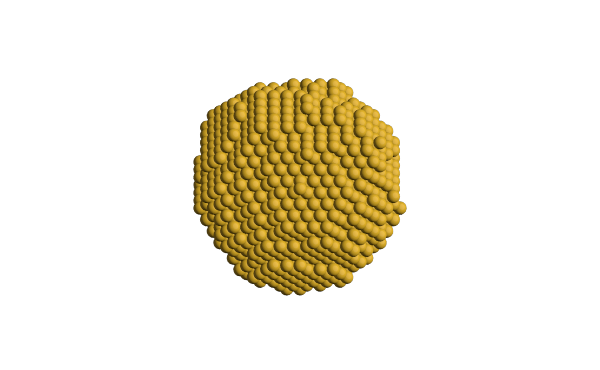

In [11]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(position), radius=np.sqrt(2)/4)
geometry.position[:] = position
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

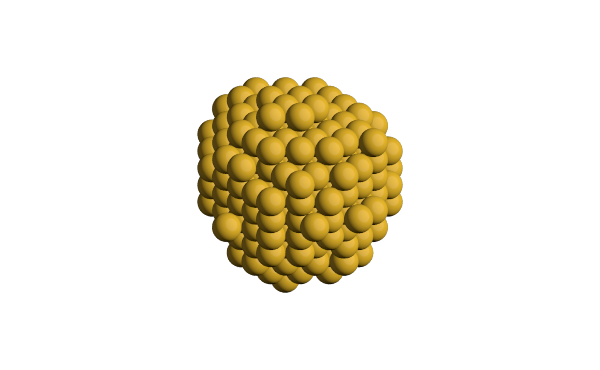

In [12]:
selected_dipoles = np.array(list(atom_num_dic.values())) == 14
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(dipole_position[selected_dipoles]), radius=np.sqrt(2)/2)
geometry.position[:] = dipole_position[selected_dipoles]
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [13]:
# Generate the trajecotry according to the dipole change which is recorded above
dipole_position = dipole_position.tolist()
dipole_change_count = np.array(dipole_change_count)
changed_dipole_index = [dipole_position.index(dipole_change_count[i][0:3].tolist()) for i in range(len(dipole_change_count))]

In [14]:
# get the initial dipole position
position = []
for x in range(-100,100):
    for y in range(-100,100):
        for z in range(-100,100):
            if abs(x)+abs(y)+abs(z)<=16:
                position.append([x,y,z])
position = np.array(position)
initial_dipole_index = [dipole_position.index(position[i].tolist()) for i in range(len(position))]

In [15]:
# check if all the changed dipoles are contained in the initial dipole configuration
# if so, we will just use the original dipole configuration to set up the system
print(sum([i in initial_dipole_index for i in np.unique(changed_dipole_index)]))
print(len(np.unique(changed_dipole_index)))

5595
5595


In [16]:
# get the changed dipole index with respect to the new dipole configuration
position = position.tolist()
changed_dipole_index = [position.index(dipole_change_count[i][0:3].tolist()) for i in range(len(dipole_change_count))]
changed_dipole_index = np.array(changed_dipole_index)
changed_dipole_type = dipole_change_count[:,3]

In [17]:
Au_dipoles = np.ones(len(position),dtype = bool)
for i in range(len(changed_dipole_index)):
    if changed_dipole_type[i] == 1:
        Au_dipoles[changed_dipole_index[i]] = True
    else:
        Au_dipoles[changed_dipole_index[i]] = False

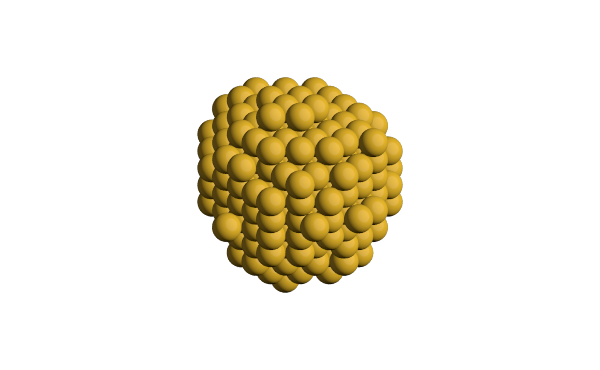

In [18]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(np.array(position)[Au_dipoles]), radius=np.sqrt(2)/2)
geometry.position[:] = np.array(position)[Au_dipoles]
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [19]:
np.savetxt('./data1/changed_dipole_index.csv',changed_dipole_index,delimiter=',')
np.savetxt('./data1/changed_dipole_type.csv',changed_dipole_type,delimiter=',')